In [ ]:
try:
    import keras_tuner
except ImportError:
    !pip install -q keras-tuner


In [ ]:
try:
    import scikeras
except ImportError:
    !pip install scikeras


Mounted at /content/drive
veri kümesi ile ilgili istatiki bilgiler
                         count        mean         std     min     25%    50%  \
air_temperature        13942.0   21.091737   11.044594  -13.00   12.00   21.0   
albedo                 13942.0    0.201426    0.026011    0.16    0.18    0.2   
azimuth                13942.0    6.794147  123.721468 -172.00 -116.00   69.0   
clearsky_dhi           13942.0   83.470664   47.979826    0.00   54.00   82.0   
clearsky_dni           13942.0  660.694664  288.846822    0.00  508.00  768.0   
clearsky_ghi           13942.0  465.097619  305.170544    1.00  192.00  466.0   
clearsky_gti           13942.0  637.133625  330.562118    1.00  411.00  717.0   
cloud_opacity          13942.0   16.550072   24.911893    0.00    0.00    0.0   
dewpoint_temp          13942.0    6.508270    4.641647  -17.60    3.80    7.3   
dhi                    13942.0  110.960120   89.460541    0.00   56.00   89.0   
dni                    13942.0  482.378497

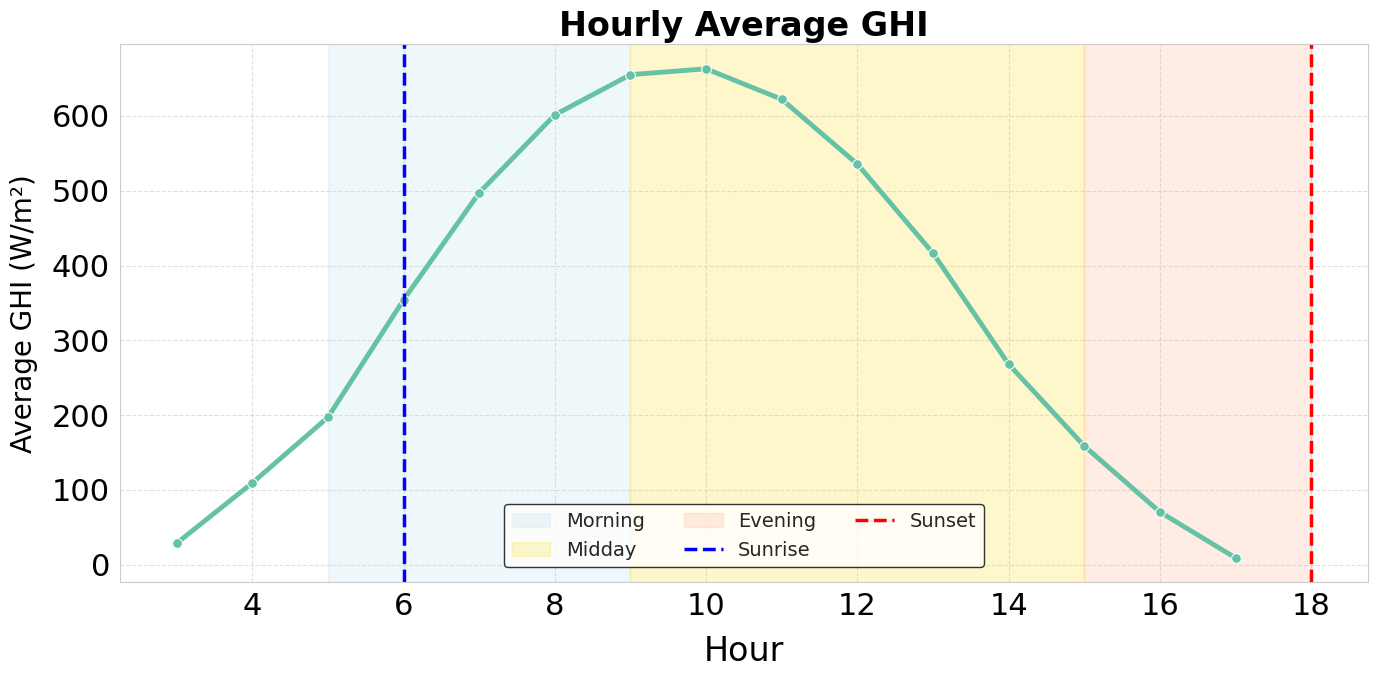

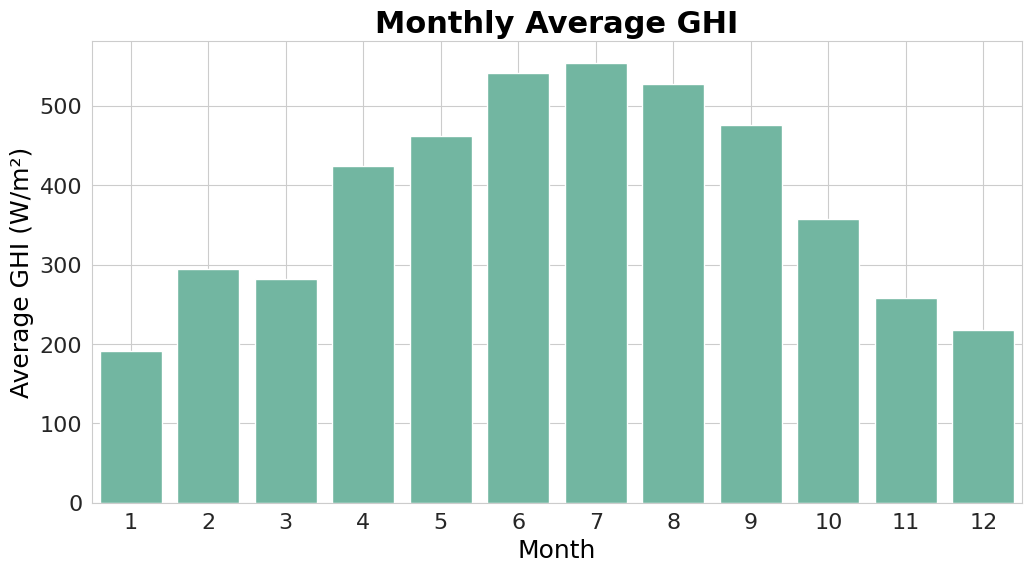

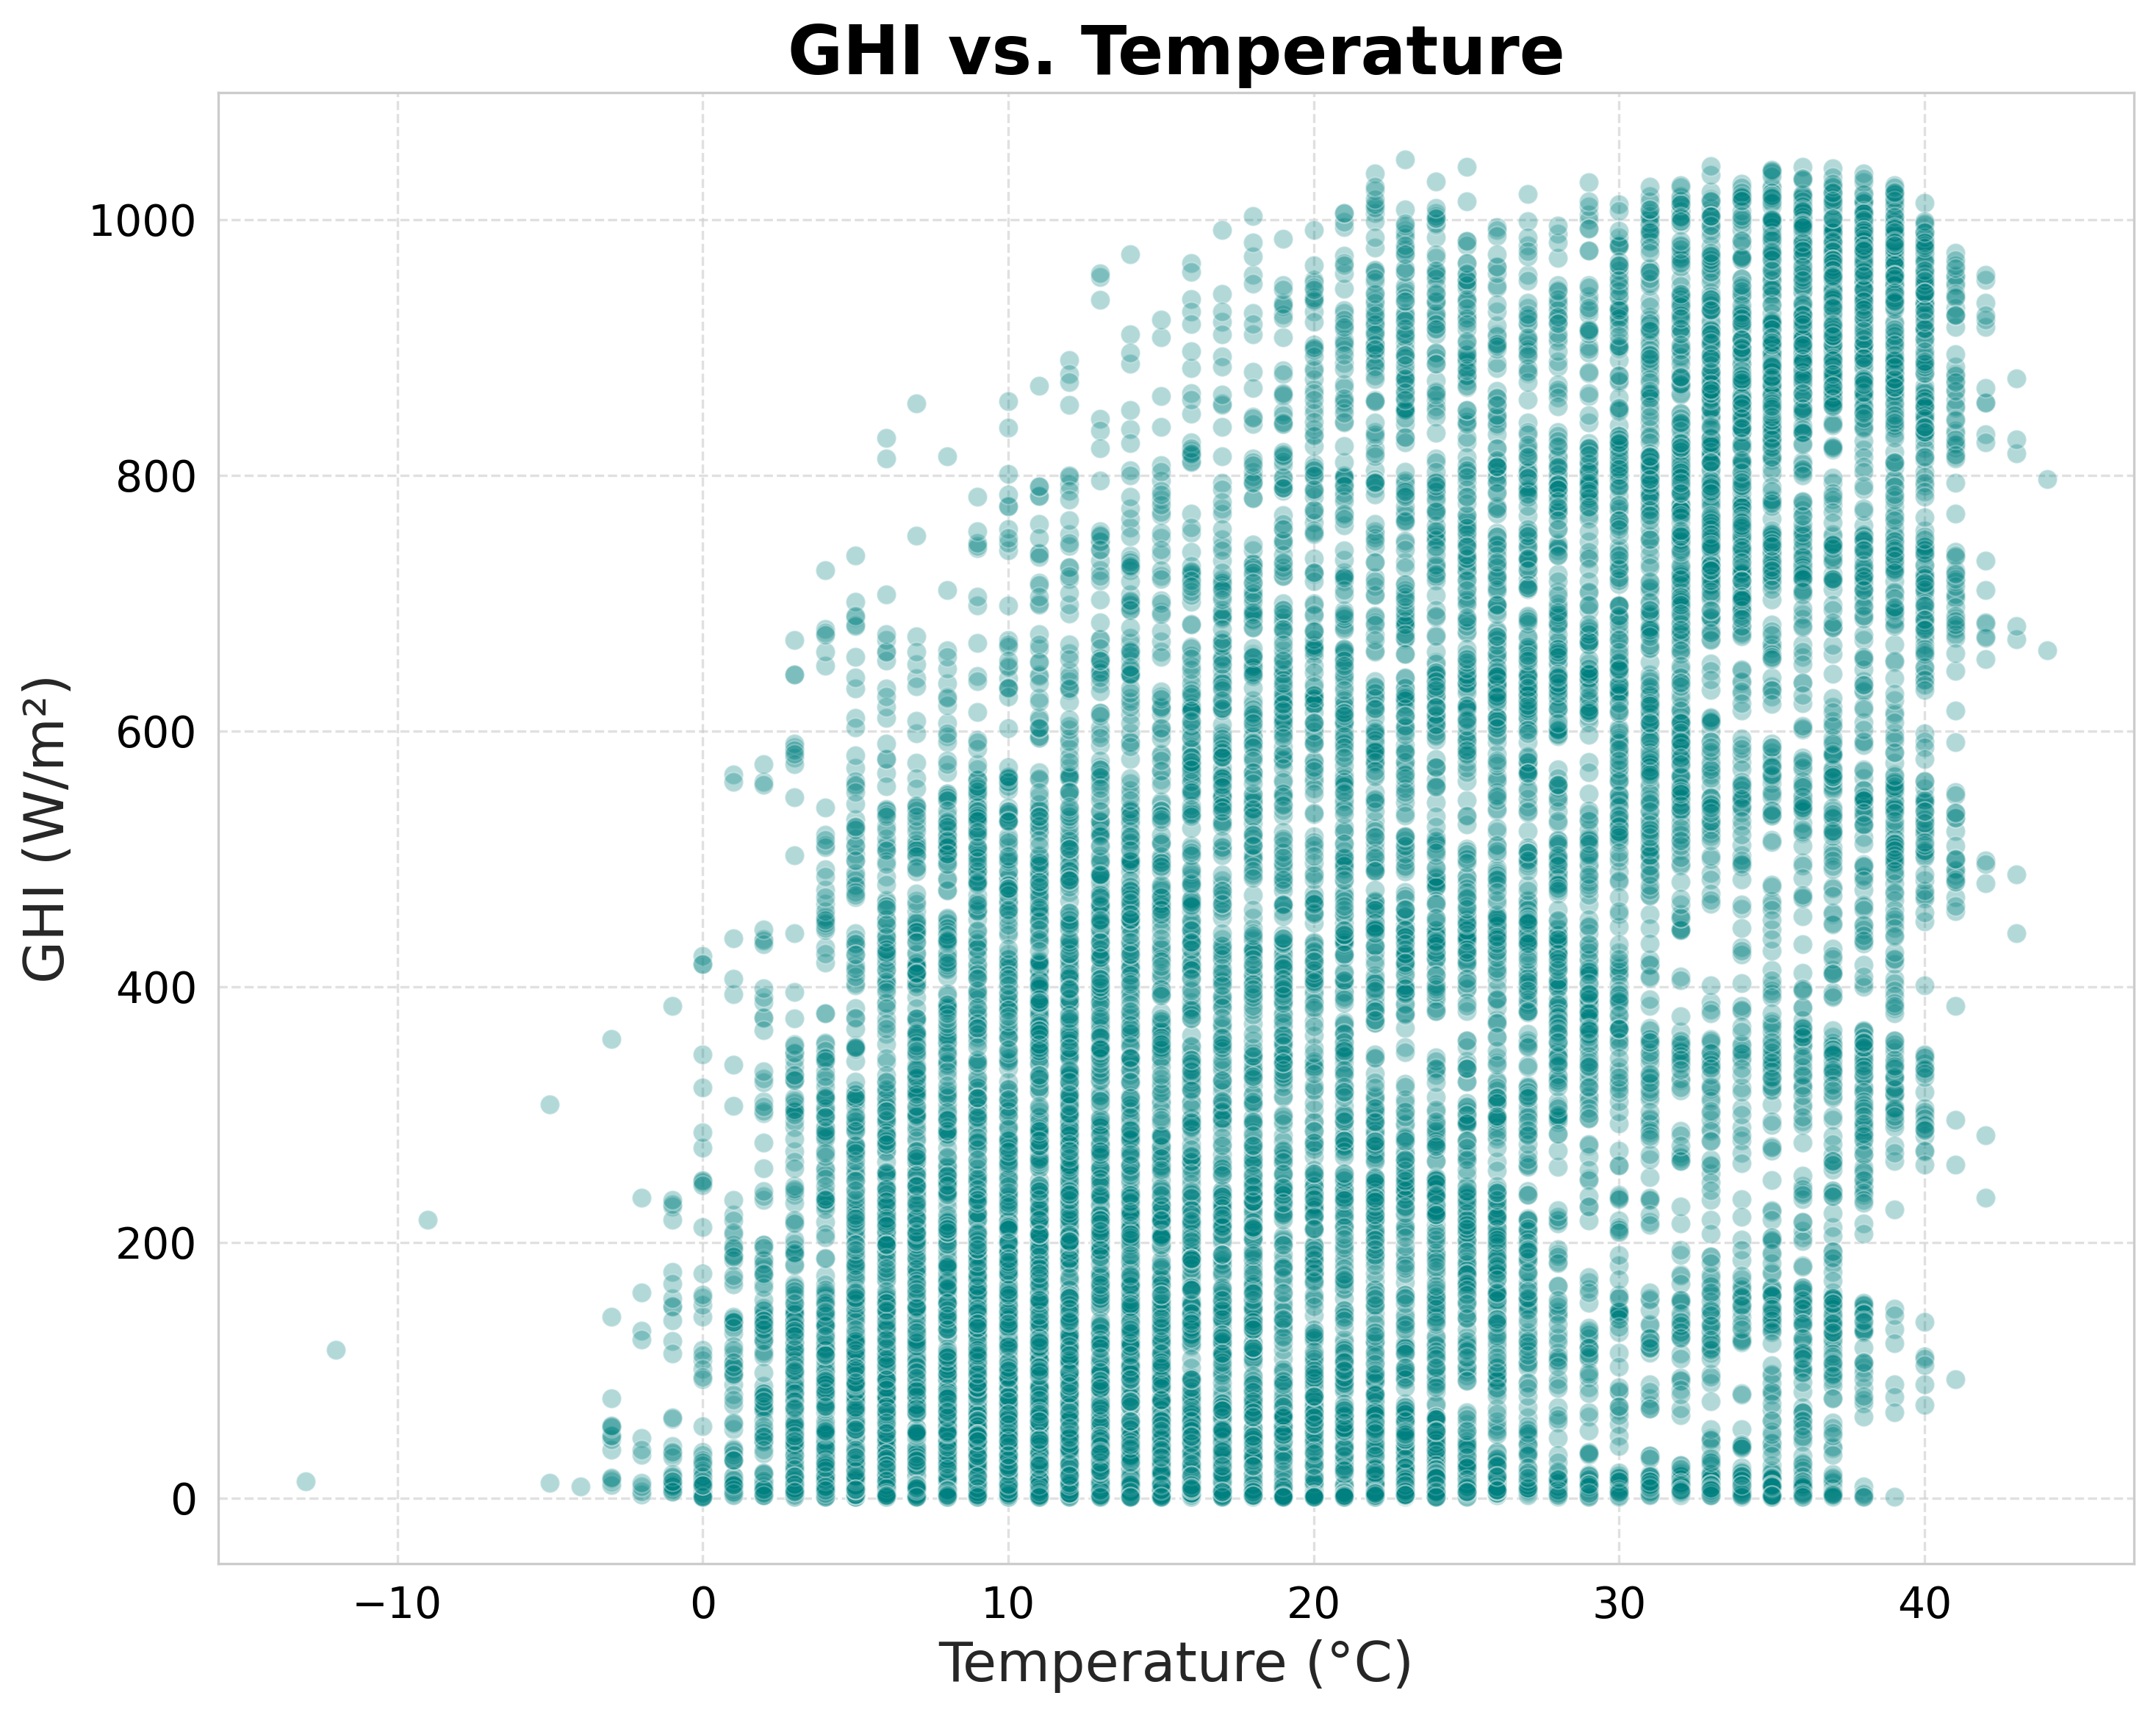

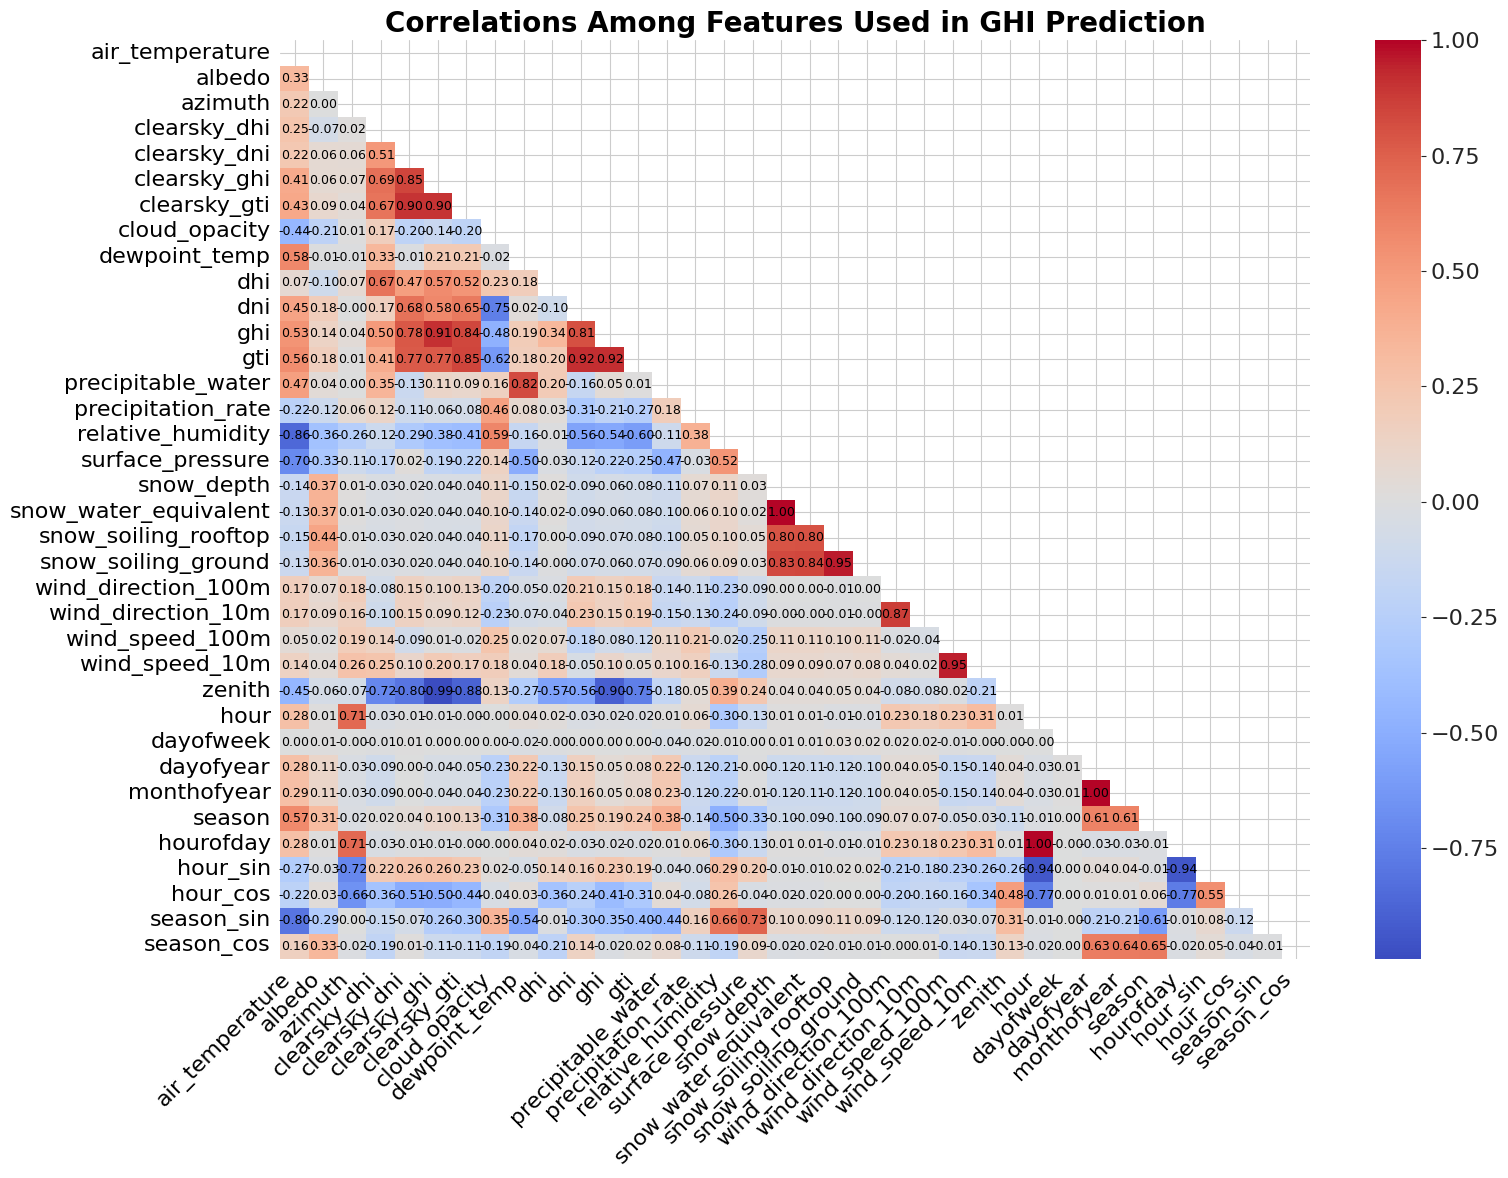

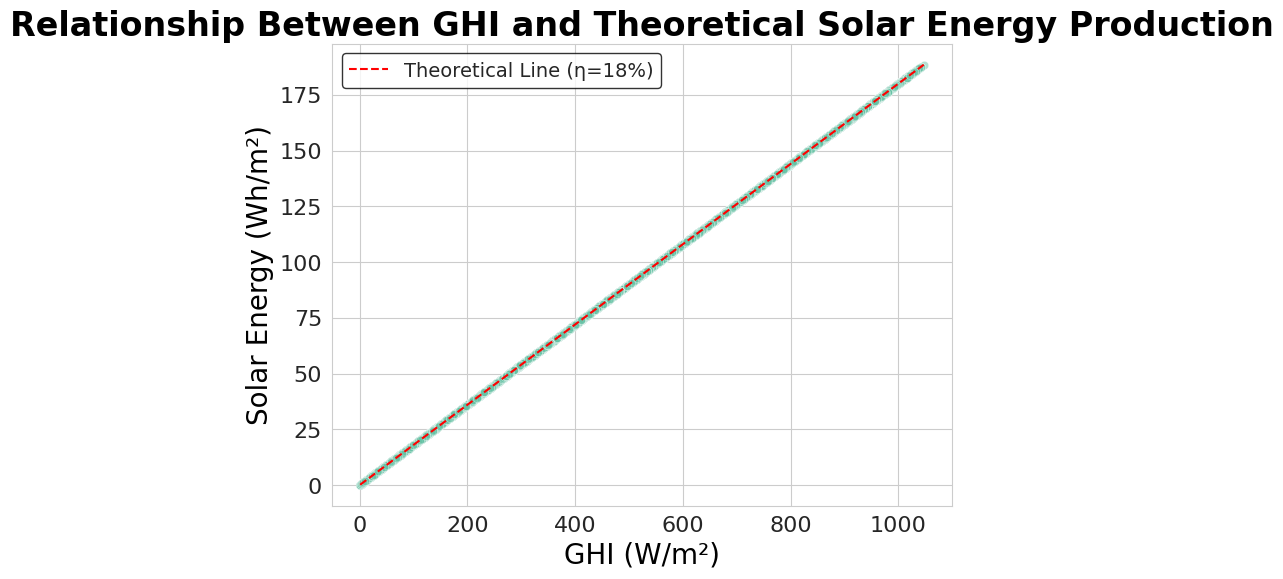

Reloading Tuner from ann_tuner/ghi_forecast/tuner0.json
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step




İlk tarih: 2022-01-01 05:00:00+00:00
Son tarih: 2025-01-01 14:00:00+00:00


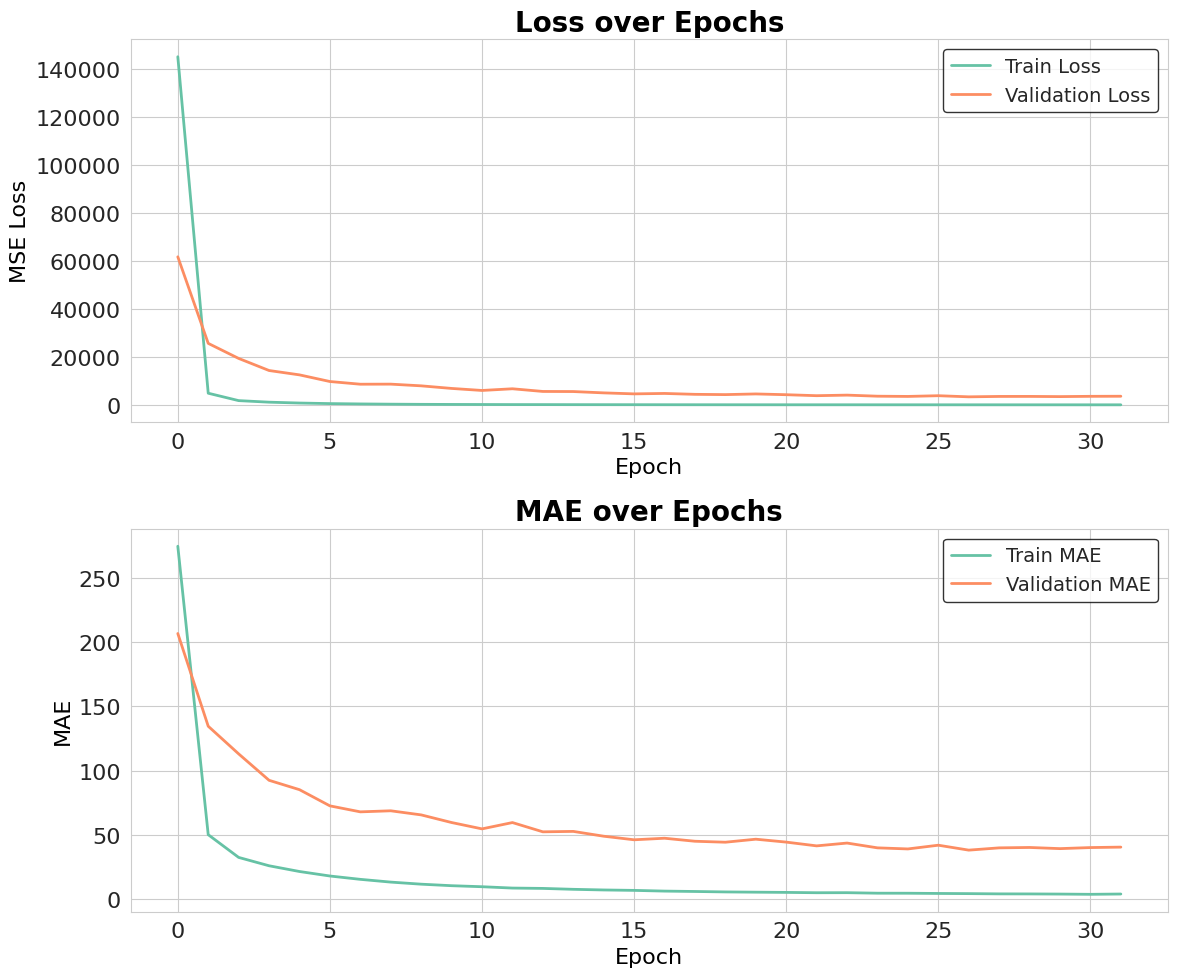

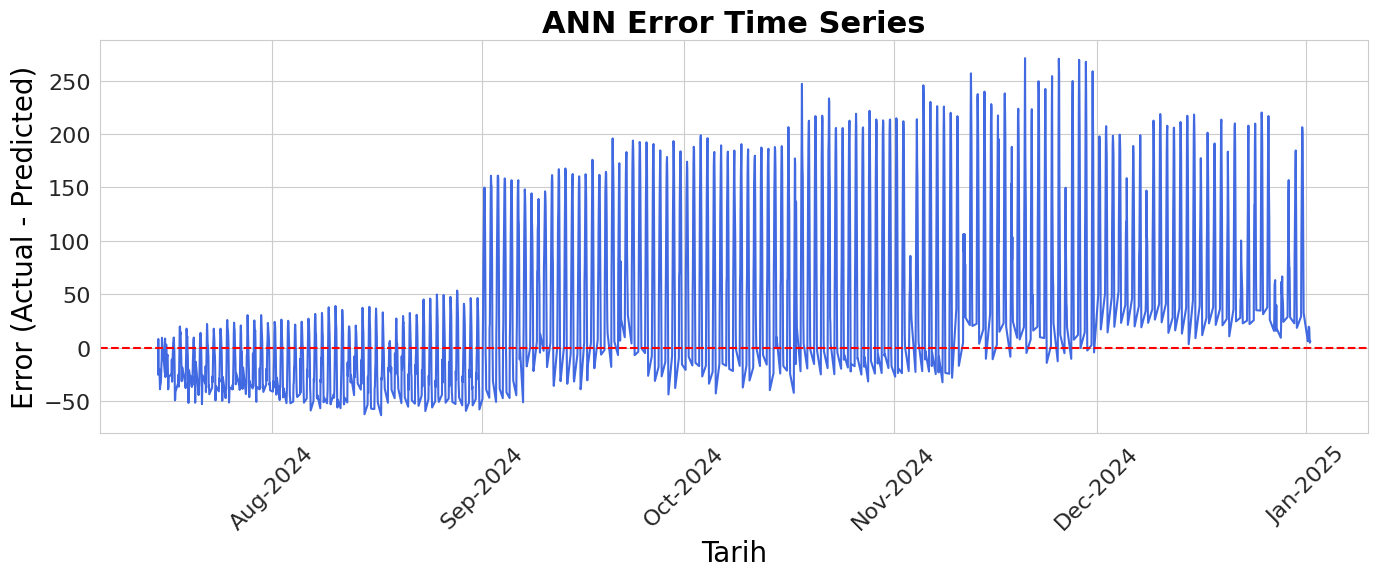

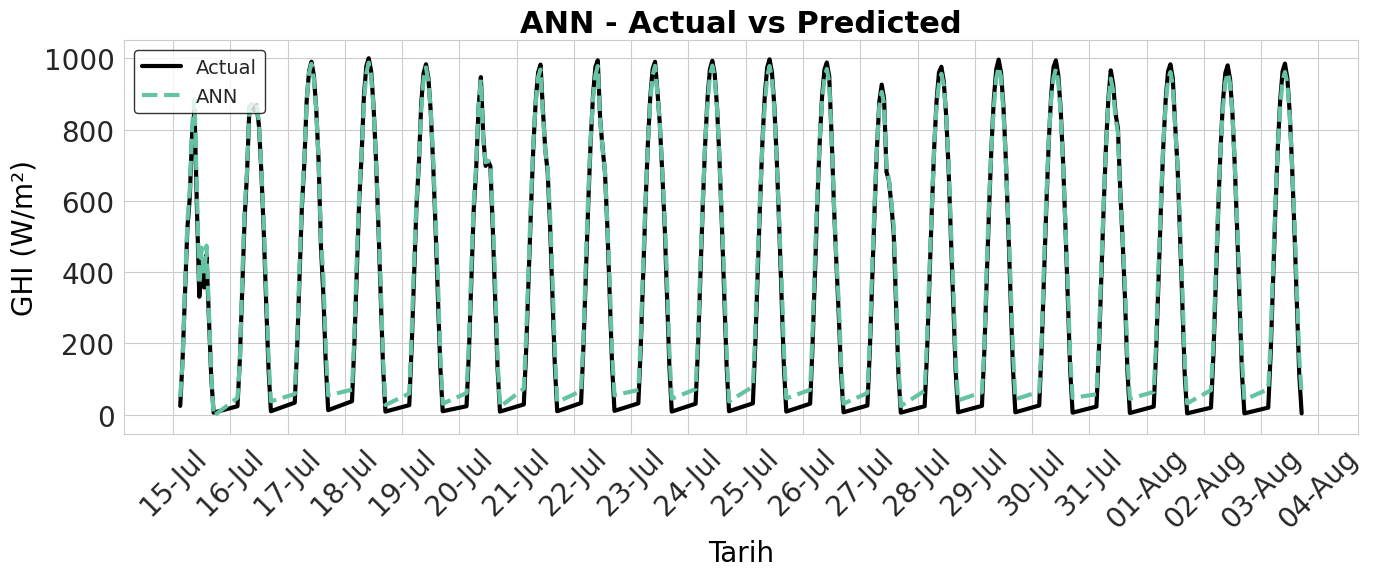

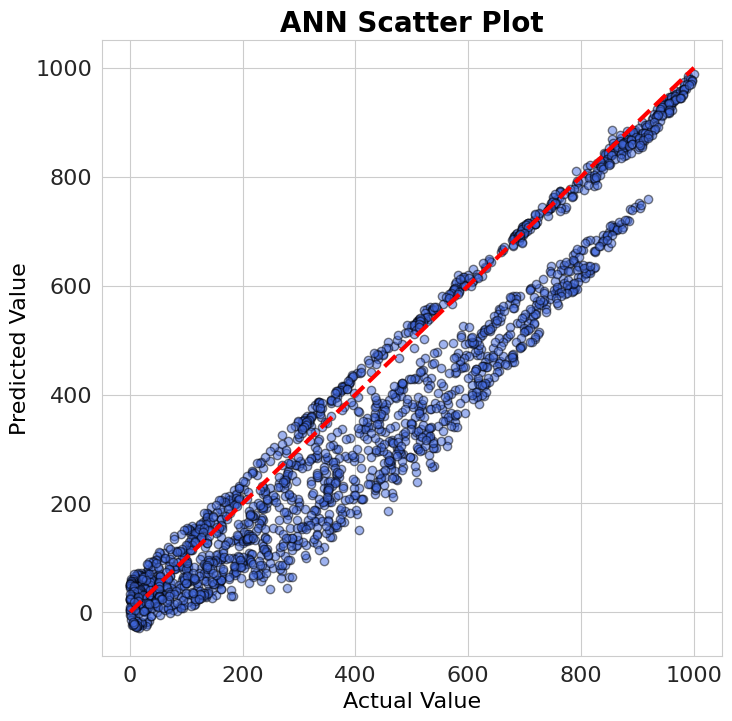

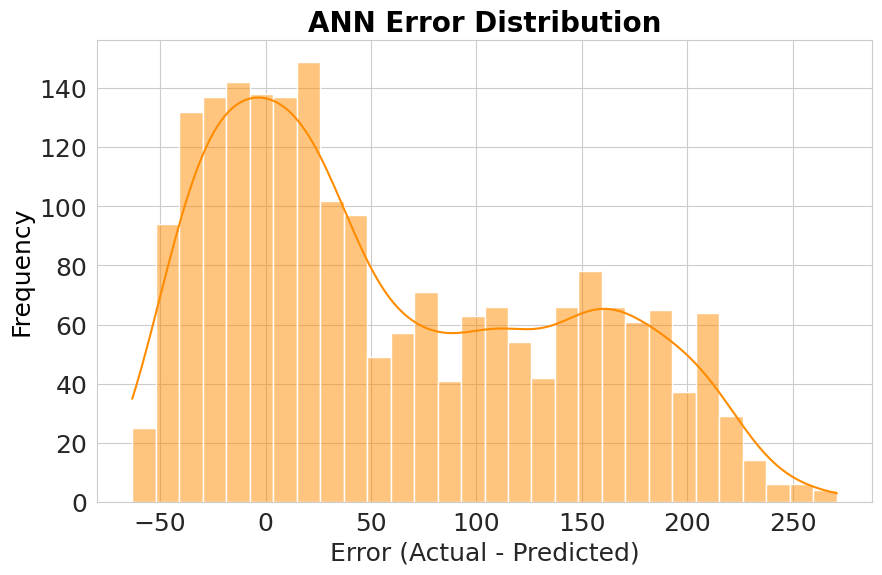

In [ ]:
import numpy as np
import os
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor  #
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib as mpl

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Check if the directory exists before changing the current working directory
directory_path = "/content/drive/MyDrive/yayınlar-bildiriler/Songül Kayık tez/bildiri/"
if os.path.exists(directory_path):
    os.chdir(directory_path)
else:
    print(f"Error: Directory not found at {directory_path}")

# Check if the file exists before reading the CSV
file_path = "/content/drive/MyDrive/yayınlar-bildiriler/Songül Kayık tez/bildiri/csv_37.83625_41.360574_horizontal_single_axis_23_0_PT60M.csv"
if os.path.exists(file_path):
    df = pd.read_csv(file_path)

    df["period_end"] = pd.to_datetime(df["period_end"])
    df = df[df["ghi"] > 0]
    df.rename(columns={'air_temp': 'air_temperature'}, inplace=True)

    # =================== VERİ ÖN İŞLEME ===================
    print( "veri kümesi ile ilgili istatiki bilgiler")
    print(df.describe().T)

    print("\n\n\n")

    print( "eksik veri var mı? ")
    print(df.isnull().sum().sort_values(ascending=False))

    # Varsayılan yazı boyutları
    mpl.rcParams['font.size'] = 14
    mpl.rcParams['axes.titlesize'] = 18
    mpl.rcParams['axes.labelsize'] = 16
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['legend.fontsize'] = 16
    mpl.rcParams['figure.titlesize'] = 20

    # Yazı renkleri siyah
    mpl.rcParams['text.color'] = 'black'
    mpl.rcParams['axes.labelcolor'] = 'black'
    mpl.rcParams['xtick.color'] = 'black'
    mpl.rcParams['ytick.color'] = 'black'
    mpl.rcParams['axes.titlecolor'] = 'black'
    mpl.rcParams['legend.edgecolor'] = 'black'  # opsiyonel



    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    if 'temperature' in df.columns and 'air_temperature' not in df.columns:
        df.rename(columns={'temperature': 'air_temperature'}, inplace=True)

    df['hour'] = df['period_end'].dt.hour
    df['dayofweek'] = df['period_end'].dt.dayofweek
    df['dayofyear'] = df['period_end'].dt.dayofyear
    df['monthofyear'] = df['period_end'].dt.month
    df['season'] = (df['monthofyear'] % 12 + 3) // 3
    df['hourofday'] = df['hour']


    df['hour_sin'] = np.sin(2 * np.pi * df['hourofday'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hourofday'] / 24)


    df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
    df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)


    df = df.drop(columns=["period", "Date", "solar_energy"], errors='ignore')


    sns.set_style("whitegrid")
    sns.set_palette("Set2")

    plt.figure(figsize=(14, 7))

    #  Ortalama çizgi
    sns.lineplot(data=df, x='hour', y='ghi', estimator='mean', ci=None,
                 linewidth=3.5, marker='o', markersize=7)

    #  Arka plan saat bölgeleri: sabah, öğle, akşam
    plt.axvspan(5, 9, color='lightblue', alpha=0.2, label='Morning')
    plt.axvspan(9, 15, color='gold', alpha=0.2, label='Midday')
    plt.axvspan(15, 18, color='lightsalmon', alpha=0.2, label='Evening')

    #  Güneş doğuş ve batış çizgileri
    plt.axvline(6, color='blue', linestyle='--', linewidth=2.5, label='Sunrise')
    plt.axvline(18, color='red', linestyle='--', linewidth=2.5, label='Sunset')

    #  Başlık ve eksenler
    plt.title("Hourly Average GHI", fontsize=24, fontweight='bold', color='black')
    plt.xlabel("Hour", fontsize=24, labelpad=10, color='black')
    plt.ylabel("Average GHI (W/m²)", fontsize=20, labelpad=10, color='black')
    plt.xticks(fontsize=22, color='black')
    plt.yticks(fontsize=22, color='black')

    #  Kılavuz çizgiler ve çerçeve
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.box(True)

    #  Açıklama kutusu
    plt.legend(loc='lower center', fontsize=14, ncol=3, bbox_to_anchor=(0.5, 0.01))



    #  Kaydet  Göster
    plt.tight_layout()
    plt.savefig("saatlik_ghi_grafik_renkli_bolgeli.png", dpi=300, bbox_inches='tight')
    plt.show()


    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='monthofyear', y='ghi', estimator='mean', ci=None)
    plt.title("Monthly Average GHI", fontsize=22, fontweight='bold')
    plt.xlabel("Month", fontsize=18, color='black')
    plt.ylabel("Average GHI (W/m²)", fontsize=18, color='black')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 8), dpi=300)
    sns.scatterplot(data=df, x='air_temperature', y='ghi',
                    alpha=0.3, edgecolor='white', s=40, color='teal')

    plt.title("GHI vs. Temperature", fontsize=22, fontweight='bold', color='black')
    plt.xlabel("Temperature (°C)", fontsize=18)
    plt.ylabel("GHI (W/m²)", fontsize=18)
    plt.xticks(fontsize=14, color='black')
    plt.yticks(fontsize=14, color='black')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("ghi_vs_sicaklik_guzel.png", dpi=300)
    plt.show()



    corr = df.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(16, 12))
    sns.heatmap(
        corr,
        mask=mask,
        cmap='coolwarm',
        annot=True,
        fmt='.2f',
        cbar=True,
        annot_kws={'size': 9, 'color': 'black'}
    )
    plt.title("Correlations Among Features Used in GHI Prediction", fontsize=20, fontweight='bold')
    plt.xticks(rotation=45, ha='right', color='black')
    plt.yticks(rotation=0, color='black')
    plt.tight_layout()
    plt.savefig("korelasyon_matrisi.png", dpi=300)
    plt.show()



    pv_efficiency = 0.18
    df['solar_energy'] = df['ghi'] * pv_efficiency



    # 🔍 GHI vs. Solar Energy Scatter Plot + Teorik Doğru
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='ghi', y='solar_energy', alpha=0.5)
    plt.plot([df['ghi'].min(), df['ghi'].max()],
             [df['ghi'].min() * pv_efficiency, df['ghi'].max() * pv_efficiency],
             'r--', label='Theoretical Line (η=18%)')
    plt.title("Relationship Between GHI and Theoretical Solar Energy Production", fontsize=24, fontweight='bold', color='black')
    plt.xlabel("GHI (W/m²)", fontsize=20, color='black')
    plt.ylabel("Solar Energy (Wh/m²)", fontsize=20, color='black')
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()



    # =================== HEDEF VE GİRDİLER ===================
    target_col = "ghi"

    X = df.drop(columns=["ghi", "period_end"])

    y = df["ghi"]

    # Zaman serisine uygun sistematik split
    split_index = int(len(df) * 0.85)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # =================== PREPROCESS ===================
    preprocessor = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    # =================== KERAS TUNER MODEL ===================
    def build_model(hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32),
                        activation='relu', input_dim=X_train_scaled.shape[1]))
        for i in range(hp.Int("num_layers", 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                            activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(
            optimizer=Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
            loss='mse',
            metrics=['mae']
        )
        return model

    #  TimeSeriesSplit ile validation set seçimi
    tscv = TimeSeriesSplit(n_splits=5)
    for train_idx, val_idx in tscv.split(X_train_scaled):
        X_tune_train, X_tune_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tune_train, y_tune_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        break

    tuner = RandomSearch(
        build_model,
        objective='val_mae',
        max_trials=5,
        executions_per_trial=1,
        directory='ann_tuner',
        project_name='ghi_forecast'
    )

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)


    tuner.search(X_tune_train, y_tune_train,
                 validation_data=(X_tune_val, y_tune_val),
                 epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)


    #  Hiperparametre sonuçlarını kaydet
    trial_summaries = []

    for trial in tuner.oracle.trials.values():
        hp_values = trial.hyperparameters.values

        # En iyi hiperparametrelerle modeli oluştur ve test setinde değerlendir
        model = tuner.hypermodel.build(trial.hyperparameters)
        model.fit(X_tune_train, y_tune_train,
                  validation_data=(X_tune_val, y_tune_val),
                  epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)
        y_pred = model.predict(X_test_scaled).flatten()

        # Performans metriklerini hesapla
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mdae = median_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100

        trial_summaries.append({
            **hp_values,
            "MAE": round(mae, 2),
            "RMSE": round(rmse, 2),
            "R²": round(r2, 2),
            "MAPE (%)": round(mape, 2),
            "MdAE": round(mdae, 2)
        })

    #  DataFrame oluştur ve CSV'ye kaydet
    trial_results_df = pd.DataFrame(trial_summaries)
    trial_results_df.to_excel("all_hyperparameter_trials.xlsx", index=False)



    # En iyi model ile eğitim
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hp)
    history = model.fit(X_tune_train, y_tune_train,
                        validation_data=(X_tune_val, y_tune_val),
                        epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)   # burayı 50 yap

    print("\n\n\n")
    print("İlk tarih:", df["period_end"].min())
    print("Son tarih:", df["period_end"].max())


    # Eğitim geçmişi çizimi
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Kayıp (Loss)
    ax[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax[0].set_title("Loss over Epochs", fontsize=20, fontweight='bold', color='black')
    ax[0].set_xlabel("Epoch", fontsize=16, color='black')
    ax[0].set_ylabel("MSE Loss", fontsize=16, color='black')
    ax[0].legend(fontsize=14)
    ax[0].grid(True)

    # MAE
    ax[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    ax[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    ax[1].set_title("MAE over Epochs", fontsize=20, fontweight='bold')
    ax[1].set_xlabel("Epoch", fontsize=16, color='black')
    ax[1].set_ylabel("MAE", fontsize=16, color='black')
    ax[1].legend(fontsize=14)
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


    # Test tahmini


    errors = y_test.values - y_pred






    # Test setine karşılık gelen zaman bilgisi
    test_dates = df['period_end'].iloc[split_index:].reset_index(drop=True)

    # Error'ların zaman eksenine karşı çizimi
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(test_dates, errors, color='royalblue')

    # 0 referans çizgisi
    ax.axhline(0, color='red', linestyle='--')

    # Tarih formatlayıcı
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Aylık gösterim
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # Örn. Jan-2024

    # X etiketi rotasyonu
    plt.xticks(rotation=45)

    # Başlık ve etiketler
    ax.set_title("ANN Error Time Series", fontsize=22, fontweight='bold', color='black')
    ax.set_xlabel("Tarih", fontsize=20, color='black')
    ax.set_ylabel("Error (Actual - Predicted)", fontsize=20, color='black')
    ax.tick_params(axis='both', labelsize=16, color='black')
    ax.grid(True)
    plt.tight_layout()
    plt.savefig("ANN_Error_TimeSeries_Timestamped.png", dpi=300)
    plt.show()








    # Gerçek zaman damgalarını test kümesine göre al
    test_dates = df['period_end'].iloc[split_index:].reset_index(drop=True)

    # İlk 300 örnek için
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(test_dates[:300], y_test.values[:300], label='Actual', color='black', linewidth=3)
    ax.plot(test_dates[:300], y_pred[:300], label='ANN', linestyle='--', linewidth=3)

    # Tarih ekseni formatlama
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Her 1 günde bir göster
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

    # Ekseni döndür (tarih etiketleri daha okunaklı olsun)
    plt.xticks(rotation=45)

    ax.set_title("ANN - Actual vs Predicted", fontsize=22, fontweight='bold', color='black')
    ax.set_xlabel("Tarih", fontsize=20, color='black')
    ax.set_ylabel("GHI (W/m²)", fontsize=20, color='black')
    ax.tick_params(axis='both', labelsize=20, color='black')
    plt.legend(loc='upper left', fontsize=14)
    plt.tight_layout()
    plt.savefig("ANN - Actual vs Predicted (Time Indexed).png", dpi=300)
    plt.show()



    # Actual vs Predicted Scatter Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(y_test, y_pred, alpha=0.5, color='royalblue', edgecolor='k')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    ax.set_title("ANN Scatter Plot", fontsize=20, fontweight='bold', color='black')
    ax.set_xlabel("Actual Value", fontsize=16, color='black')
    ax.set_ylabel("Predicted Value", fontsize=16, color='black')
    ax.tick_params(axis='both', labelsize=16, color='black')
    ax.grid(True)
    plt.savefig("ANN Scatter Plot.png", dpi=300)
    plt.show()

    # Error Histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(errors, bins=30, kde=True, ax=ax, color='darkorange')
    ax.set_title("ANN Error Distribution", fontsize=20, fontweight='bold', color='black')
    ax.set_xlabel("Error (Actual - Predicted)", fontsize=18)
    ax.set_ylabel("Frequency", fontsize=18, color='black')
    ax.tick_params(axis='both', labelsize=18, color='black')
    ax.grid(True)
    plt.savefig("ANN Error Distribution", dpi=300)
    plt.show()

else:
    print(f"Error: File not found at {file_path}")
    # You might want to exit or handle this error appropriately
    # For now, I will stop the execution here if the file is not found
    # exit() # Removed exit() to prevent NameError